## Grant's Garbage Regression Model of Potential Revenue

### 2023 Feb 3 Code Jam

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3 
import json
import psycopg2

from data_sci_toolkit.common_tools import config_tools
from data_sci_toolkit.aws_tools import redshift_tools
from pycaret.classification import *

#### Plan for untapped segments
- grab subset of the untapped demographics
- Summarize total number of fans missed
- ML determine potential missed revenue

In [52]:
CNXN = redshift_tools.get_redshift_connection("prod-app", "stlrlakings")

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


In [53]:
cursor = CNXN.cursor()

select_sql = f"""
    SELECT c.dimcustomermasterid, gender, income, avidity, distancetovenue, frequency_tier_overall, monetary_tier_overall, engagementbucket, sourceTenure, age, ethnicity, engagementmomentumbucket, sum(revenue) 
    FROM stlrlakings.dw.cohortcustomer c
    left join stlrlakings.dw.cohortpurchase p
        on c.dimcustomermasterid = p.dimcustomermasterid
    group by c.dimcustomermasterid, gender, income, avidity, distancetovenue, frequency_tier_overall, monetary_tier_overall, engagementbucket, sourceTenure, age, ethnicity, engagementmomentumbucket
"""

df_cohortcustomer = pd.read_sql(select_sql, CNXN)

display(df_cohortcustomer)

,dimcustomermasterid,gender,income,avidity,distancetovenue,frequency_tier_overall,monetary_tier_overall,engagementbucket,sourcetenure,age,ethnicity,engagementmomentumbucket,sum
0,211762870,None,None,Lite,NaN,None,None,No Data,None,NaN,None,No Data,NaN
1,211762889,None,None,None,NaN,None,None,No Data,None,NaN,None,No Data,NaN
2,211762943,None,None,None,NaN,None,None,No Data,None,NaN,None,No Data,NaN
3,211762987,None,None,None,NaN,None,None,No Data,None,NaN,None,No Data,NaN
4,211763046,None,None,None,NaN,None,None,No Data,None,NaN,None,No Data,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
718376,310379594,None,None,Casual,72.69,None,None,No Data,None,NaN,None,No Data,NaN
718377,310380093,None,None,Lite,3329.76,None,None,No Data,None,NaN,None,No Data,NaN
718378,310380357,Female,250000,Casual,3502.53,1,2,No Data,1900,55.0,Hispanic,No Data,258.0
718379,310380378,None,None,Lite,15.69,None,None,No Data,None,NaN,None,No Data,NaN


In [54]:
df = df_cohortcustomer

In [55]:
df = df.rename(columns={'sum': 'revenue'})

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718381 entries, 0 to 718380
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dimcustomermasterid       718381 non-null  int64  
 1   gender                    53655 non-null   object 
 2   income                    51692 non-null   object 
 3   avidity                   477357 non-null  object 
 4   distancetovenue           274160 non-null  float64
 5   frequency_tier_overall    75836 non-null   object 
 6   monetary_tier_overall     75836 non-null   object 
 7   engagementbucket          718381 non-null  object 
 8   sourcetenure              174440 non-null  object 
 9   age                       51094 non-null   float64
 10  ethnicity                 56347 non-null   object 
 11  engagementmomentumbucket  718381 non-null  object 
 12  revenue                   92127 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory us

## Training Preprocess Steps:

In [57]:
# create training and eval datasets
df_train = df.sample(frac=0.8, random_state=786)
df_eval = df.drop(df_train.index)
df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Training: ' + str(df_train.shape))
print('Data for Evaluation: ' + str(df_eval.shape), end="\n")

Data for Training: (574705, 13)
Data for Evaluation: (143676, 13)


In [58]:
from pycaret.regression import *

setup(
    data = df_train, 
    target = "revenue", 
    train_size = 0.85,
    data_split_shuffle = True,
    ignore_features = ['dimcustomermasterid', 'income', 'distancetovenue', 'gender', 'engagementbucket', 'ethnicity'],
    categorical_features=["engagementmomentumbucket", 'avidity', 'monetary_tier_overall'],
    numeric_features = ['frequency_tier_overall', 'sourcetenure', 'age'],
    silent = True,
    verbose = False,
    session_id=100
);

In [59]:
model_matrix = compare_models(
    fold = 10
)

IntProgress(value=0, description='Processing: ', max=99)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:46:12
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,AdaBoost Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,3461.8405,2001961215.7662,24932.9236,0.2330,2.2455,5.7470,0.0240
br,Bayesian Ridge,3581.0638,2001891540.1126,24954.9536,0.2299,2.3287,6.1362,0.0490
lasso,Lasso Regression,3607.8766,2002014594.4000,24960.5698,0.2292,2.3291,6.2726,0.3000
lr,Linear Regression,3610.2733,2002019343.2000,24960.9072,0.2291,2.3291,6.2838,0.0500
ridge,Ridge Regression,3610.1549,2002018988.0000,24960.8849,0.2291,2.3290,6.2832,0.1710
lar,Least Angle Regression,3610.2865,2002020203.6987,24960.9505,0.2291,2.3291,6.2828,0.0240
omp,Orthogonal Matching Pursuit,4226.5210,2004091374.5618,25023.9080,0.2216,2.7771,10.1444,0.0200
en,Elastic Net,3165.1061,2013148742.4000,25168.2966,0.2069,2.4324,5.6934,0.1700
huber,Huber Regressor,2340.5927,2041400927.6275,26008.6207,0.0997,1.8246,1.1369,0.5020
dt,Decision Tree Regressor,2339.0393,2039314381.3715,25966.9187,0.0942,1.4866,0.9257,0.0320


/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.69396e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.6585e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.78384e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.71283e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: I

In [ ]:
best_model = create_model(model_matrix, fold=10);
final_model = finalize_model(best_model);

ValueError: Estimator [] does not have the required fit() method.

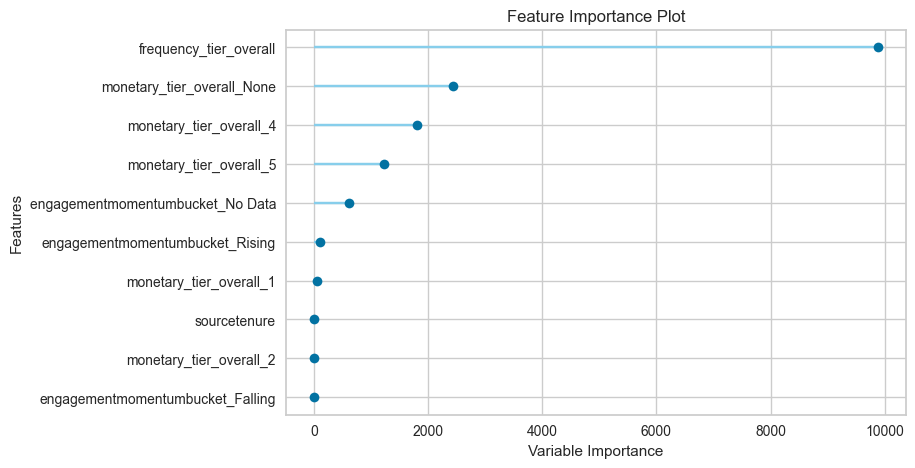

In [ ]:
plot_model(final_model, plot='feature')

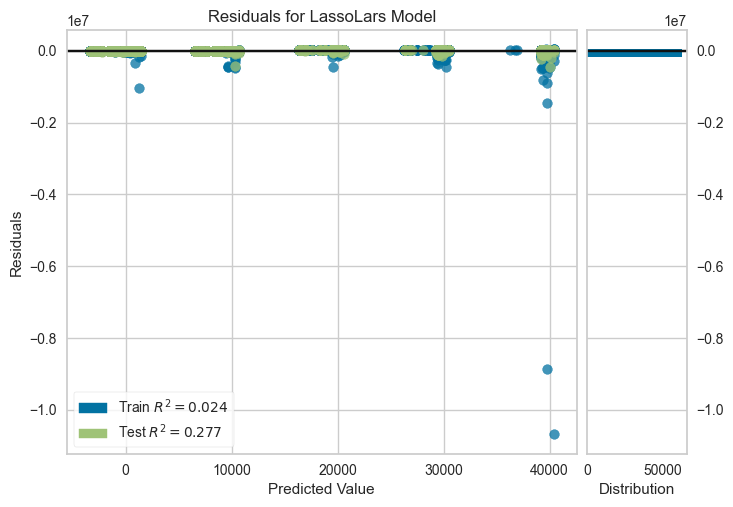

In [ ]:
plot_model(final_model)

In [29]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Inference Prepipeline Steps:

In [30]:
cursor = CNXN.cursor()

select_sql = f"""
    drop table if exists #ee;
    select cc.dimcustomermasterid into #ee from dw.cohortcustomer cc left join dw.cohortmarketing cm on cc.dimcustomermasterid = cm.dimcustomermasterid and cm.activitydate between '2022-09-01' and '2023-02-03'  group by cm.dimcustomermasterid, cc.dimcustomermasterid having sum(cm.numSends) = 0 or cm.dimcustomermasterid is null;

    drop table if exists #ct;
    SELECT c.dimcustomermasterid, gender, income, avidity, distancetovenue, frequency_tier_overall, monetary_tier_overall, engagementbucket, sourceTenure, age, ethnicity, engagementmomentumbucket, sum(revenue)
    into #ct
    FROM stlrlakings.dw.cohortcustomer c
    left join stlrlakings.dw.cohortpurchase p
        on c.dimcustomermasterid = p.dimcustomermasterid
    where p.seasonyear = 2022
    group by c.dimcustomermasterid, gender, income, avidity, distancetovenue, frequency_tier_overall, monetary_tier_overall, engagementbucket, sourceTenure, age, ethnicity, engagementmomentumbucket;

    select * from #ct ct join #ee ee on ct.dimcustomermasterid = ee.dimcustomermasterid
"""

df_inference = pd.read_sql(select_sql, CNXN)

display(df_inference)

,dimcustomermasterid,gender,income,avidity,distancetovenue,frequency_tier_overall,monetary_tier_overall,engagementbucket,sourcetenure,age,ethnicity,engagementmomentumbucket,sum,dimcustomermasterid
0,173338012,Male,None,None,1.49,None,None,No Data,1900,NaN,White/Other,No Data,NaN,173338012
1,173381266,Male,87499,Casual,57.25,2,5,No Data,1900,33.0,Hispanic,No Data,NaN,173381266
2,173312898,Male,69999,Avid,92.80,1,1,No Data,1900,45.0,White/Other,No Data,221.0,173312898
3,173384896,None,None,Avid,20.02,1,1,No Data,1900,NaN,None,No Data,104.0,173384896
4,173443961,Female,124999,Avid,31.54,2,5,No Data,2022,25.0,White/Other,No Data,3959.0,173443961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42983,173325944,None,None,Avid,30.84,1,1,No Data,1900,NaN,None,No Data,100.0,173325944
42984,310888797,None,None,None,62.53,None,None,No Data,None,NaN,None,No Data,NaN,310888797
42985,310888949,None,None,None,NaN,None,None,No Data,None,NaN,None,No Data,NaN,310888949
42986,310906733,None,None,None,20.99,None,None,No Data,None,NaN,None,No Data,NaN,310906733


## Inference Preprocess Steps:

In [31]:
df_inference = df_inference.rename(columns={'sum': 'revenue'})

# remove the target column from inference df
df_inference = df_inference.drop(columns=["revenue"], axis=1)

print('Data for Inference: ' + str(df_inference.shape), end="\n")

Data for Inference: (42988, 13)


## Inference Steps:

In [32]:
df_scores = predict_model(final_model, data=df_inference)

In [33]:
df_scores

,dimcustomermasterid,gender,income,avidity,distancetovenue,frequency_tier_overall,monetary_tier_overall,engagementbucket,sourcetenure,age,ethnicity,engagementmomentumbucket,dimcustomermasterid,Label
0,173338012,Male,None,None,1.49,None,None,No Data,1900,NaN,White/Other,No Data,173338012,1417.167327
1,173381266,Male,87499,Casual,57.25,2,5,No Data,1900,33.0,Hispanic,No Data,173381266,10741.749883
2,173312898,Male,69999,Avid,92.80,1,1,No Data,1900,45.0,White/Other,No Data,173312898,-316.888466
3,173384896,None,None,Avid,20.02,1,1,No Data,1900,NaN,None,No Data,173384896,-316.888466
4,173443961,Female,124999,Avid,31.54,2,5,No Data,2022,25.0,White/Other,No Data,173443961,10267.664318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42983,173325944,None,None,Avid,30.84,1,1,No Data,1900,NaN,None,No Data,173325944,-316.888466
42984,310888797,None,None,None,62.53,None,None,No Data,None,NaN,None,No Data,310888797,1295.510898
42985,310888949,None,None,None,NaN,None,None,No Data,None,NaN,None,No Data,310888949,1295.510898
42986,310906733,None,None,None,20.99,None,None,No Data,None,NaN,None,No Data,310906733,1295.510898


In [34]:
df_scores["Label"].value_counts(bins=10)

(1123.43, 5484.054]               37334
(-3280.8010000000004, 1123.43]     4793
(5484.054, 9844.678]                340
(9844.678, 14205.302]               197
(27287.174, 31647.798]              112
(18565.926, 22926.55]               111
(36008.422, 40369.046]               84
(14205.302, 18565.926]               17
(22926.55, 27287.174]                 0
(31647.798, 36008.422]                0
Name: Label, dtype: int64

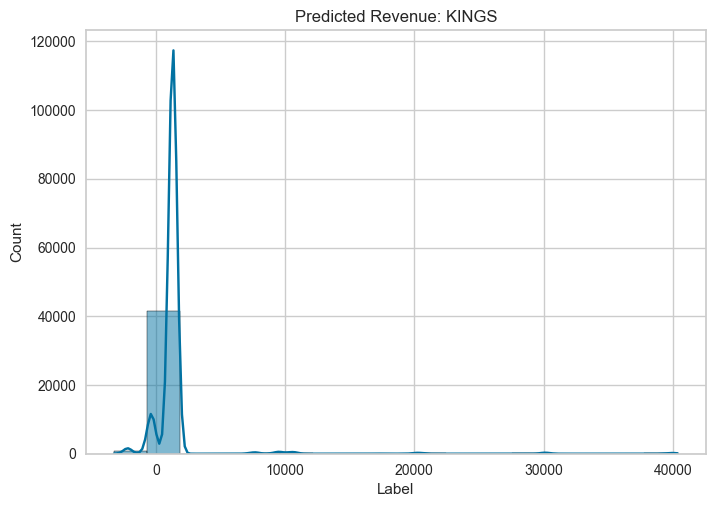

In [35]:
sns.histplot(data=df_scores, x='Label', kde=True)  
plt.title(f"Predicted Revenue: KINGS", fontsize = 12);

#### Not enough time to figure out the model right and figure out features so I am just taking 10% of my estimate as a proof of concept

In [40]:
sum(df_scores["Label"])*0.1

6156173.163793363